In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fredapi import Fred
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)


In [4]:
from config import FRED_API_KEY
# Initialize FRED API
fred = Fred(api_key=FRED_API_KEY)

In [49]:
# Set time period 
end_date = datetime.now()
start_date = '2015-01-01'

yield_10y = fred.get_series('DGS10')[start_date:end_date]    
yield_2y = fred.get_series('DGS2')[start_date:end_date]

treasury_data = pd.DataFrame({
    '10Y_Treasury_Yield': yield_10y,
    '2Y_Treasury_Yield': yield_2y
})

treasury_data = treasury_data.reset_index()
treasury_data.rename(columns={'index': 'Date'}, inplace=True)  # Optional: rename the column to 'Date'

# Display first few rows
print(treasury_data.head())
print(treasury_data.tail())

        Date  10Y_Treasury_Yield  2Y_Treasury_Yield
0 2015-01-01                 NaN                NaN
1 2015-01-02                2.12               0.66
2 2015-01-05                2.04               0.68
3 2015-01-06                1.97               0.65
4 2015-01-07                1.96               0.62
           Date  10Y_Treasury_Yield  2Y_Treasury_Yield
2749 2025-07-16                4.46               3.88
2750 2025-07-17                4.47               3.91
2751 2025-07-18                4.44               3.88
2752 2025-07-21                4.38               3.85
2753 2025-07-22                4.35               3.83


In [50]:
#timegpt require there is no missing data for daily data, so we need to fill the missing data
#and the data cannot have gap in the time series

# Ensure Date is datetime and set as index
treasury_data['ds'] = pd.to_datetime(treasury_data['Date'])

#fill the missing date
#utilsforecast, a Python package from Nixtla that provides essential utilities for time series forecasting, such as functions for data preprocessing, plotting, and evaluation.
from utilsforecast.preprocessing import fill_gaps
#but for this function, it require date column to be named as ds
treasury_data['unique_id'] = 'id1'
treasury_data= treasury_data[['unique_id', 'ds', '10Y_Treasury_Yield', '2Y_Treasury_Yield']]
treasury_data = fill_gaps(treasury_data, freq='D')

#this fill_gapsfunction is to fill the missing date, but we also need to fill the missing value, for finance, we usually use the number from previous trading day
treasury_data = treasury_data.ffill()

#if the first number is missing and it doesn't have previous traidng day number, we can just delete it
treasury_data = treasury_data.dropna()

# Display first few rows
print(treasury_data.head())
print(treasury_data.tail())

treasury_data.isna().sum()


  unique_id         ds  10Y_Treasury_Yield  2Y_Treasury_Yield
1       id1 2015-01-02                2.12               0.66
2       id1 2015-01-03                2.12               0.66
3       id1 2015-01-04                2.12               0.66
4       id1 2015-01-05                2.04               0.68
5       id1 2015-01-06                1.97               0.65
     unique_id         ds  10Y_Treasury_Yield  2Y_Treasury_Yield
3851       id1 2025-07-18                4.44               3.88
3852       id1 2025-07-19                4.44               3.88
3853       id1 2025-07-20                4.44               3.88
3854       id1 2025-07-21                4.38               3.85
3855       id1 2025-07-22                4.35               3.83


unique_id             0
ds                    0
10Y_Treasury_Yield    0
2Y_Treasury_Yield     0
dtype: int64

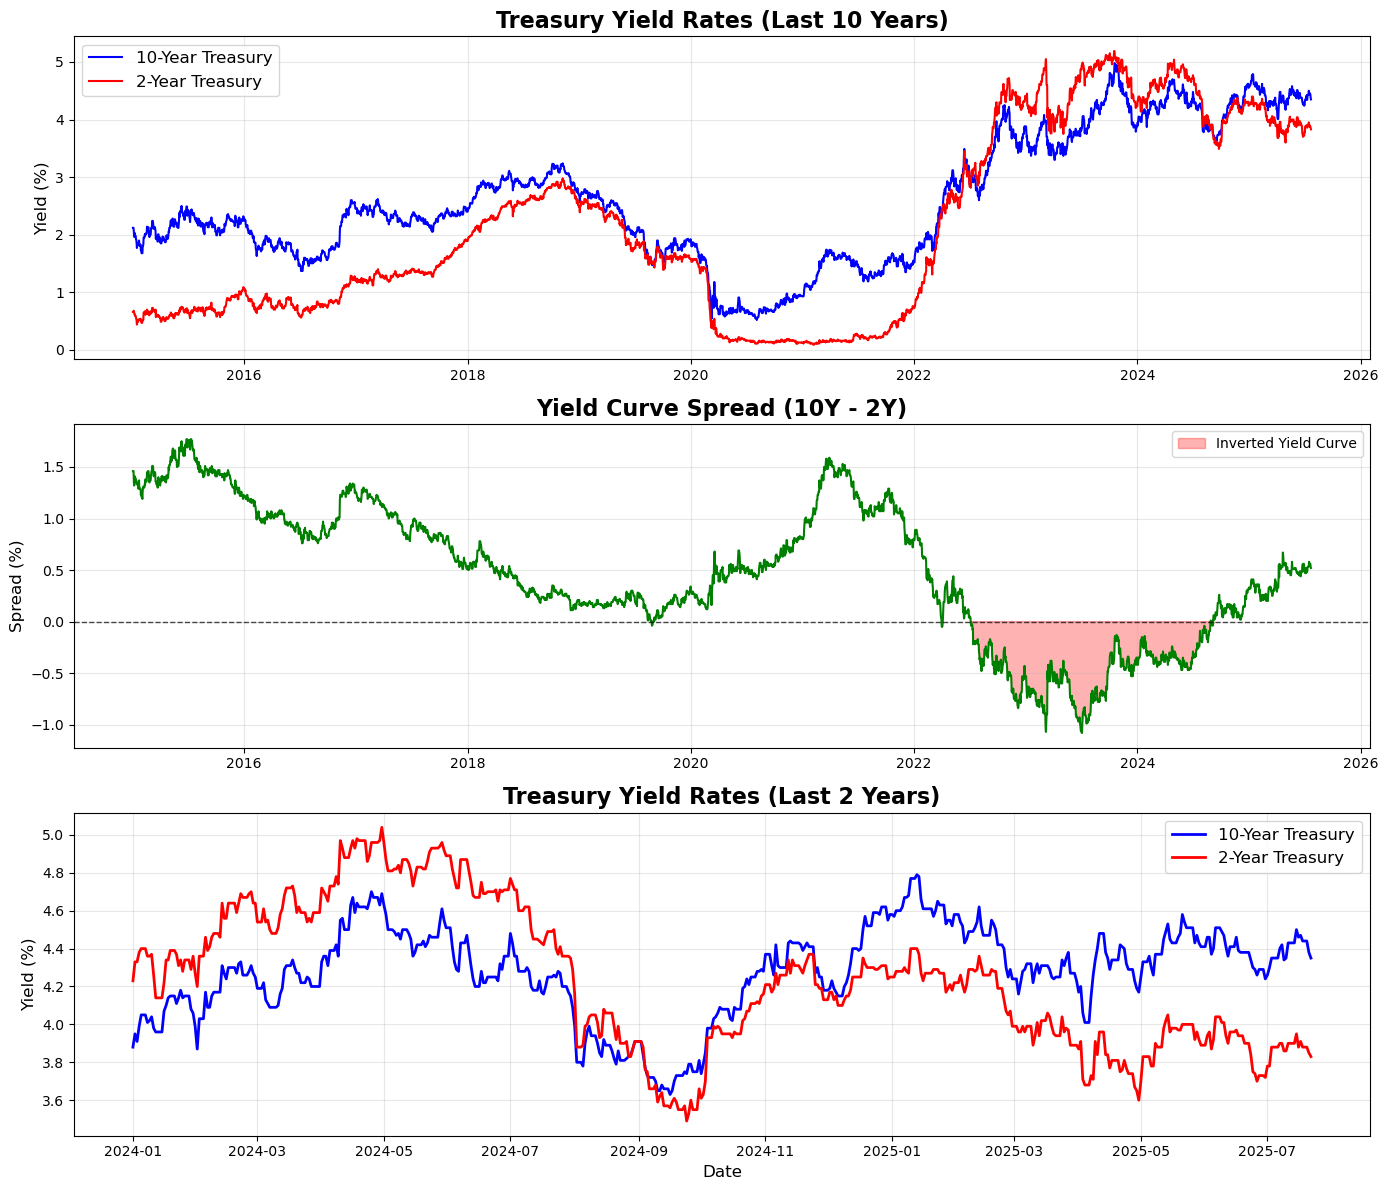

In [46]:
#set index as date
treasury_data_plot = treasury_data.set_index('ds')

# Create comprehensive visualization
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

# Plot 1: Both treasury yields
axes[0].plot(treasury_data_plot.index, treasury_data_plot['10Y_Treasury_Yield'], 
            label='10-Year Treasury', linewidth=1.5, color='blue')
axes[0].plot(treasury_data_plot.index, treasury_data_plot['2Y_Treasury_Yield'], 
            label='2-Year Treasury', linewidth=1.5, color='red')
axes[0].set_title('Treasury Yield Rates (Last 10 Years)', fontsize=16, fontweight='bold')
axes[0].set_ylabel('Yield (%)', fontsize=12)
axes[0].legend(fontsize=12)
axes[0].grid(True, alpha=0.3)

# Plot 2: Yield spread (10Y - 2Y)
yield_spread = treasury_data_plot['10Y_Treasury_Yield'] - treasury_data_plot['2Y_Treasury_Yield']
axes[1].plot(yield_spread.index, yield_spread, color='green', linewidth=1.5)
axes[1].axhline(y=0, color='black', linestyle='--', alpha=0.7, linewidth=1)
axes[1].set_title('Yield Curve Spread (10Y - 2Y)', fontsize=16, fontweight='bold')
axes[1].set_ylabel('Spread (%)', fontsize=12)
axes[1].grid(True, alpha=0.3)

# Highlight inverted yield curve periods (negative spread)
negative_spread = yield_spread < 0
if negative_spread.any():
    axes[1].fill_between(yield_spread.index, yield_spread, 0, 
                        where=negative_spread, alpha=0.3, color='red', 
                        label='Inverted Yield Curve')
    axes[1].legend()

# Plot 3: Recent data (last 2 years)
recent_data = treasury_data_plot.last('2Y')
axes[2].plot(recent_data.index, recent_data['10Y_Treasury_Yield'], 
            label='10-Year Treasury', linewidth=2, color='blue')
axes[2].plot(recent_data.index, recent_data['2Y_Treasury_Yield'], 
            label='2-Year Treasury', linewidth=2, color='red')
axes[2].set_title('Treasury Yield Rates (Last 2 Years)', fontsize=16, fontweight='bold')
axes[2].set_xlabel('Date', fontsize=12)
axes[2].set_ylabel('Yield (%)', fontsize=12)
axes[2].legend(fontsize=12)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [42]:
from nixtla import NixtlaClient
from config import NIXTLA_API_KEY

nixtla_client = NixtlaClient(
    api_key=NIXTLA_API_KEY
)

#Verify the status and validity of your API key:
nixtla_client.validate_api_key()
#The validate_api_key() method will return Happy Forecasting! :)

INFO:nixtla.nixtla_client:Happy Forecasting! :)


True

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: D
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


unique_id    0
ds           0
y            0
dtype: int64


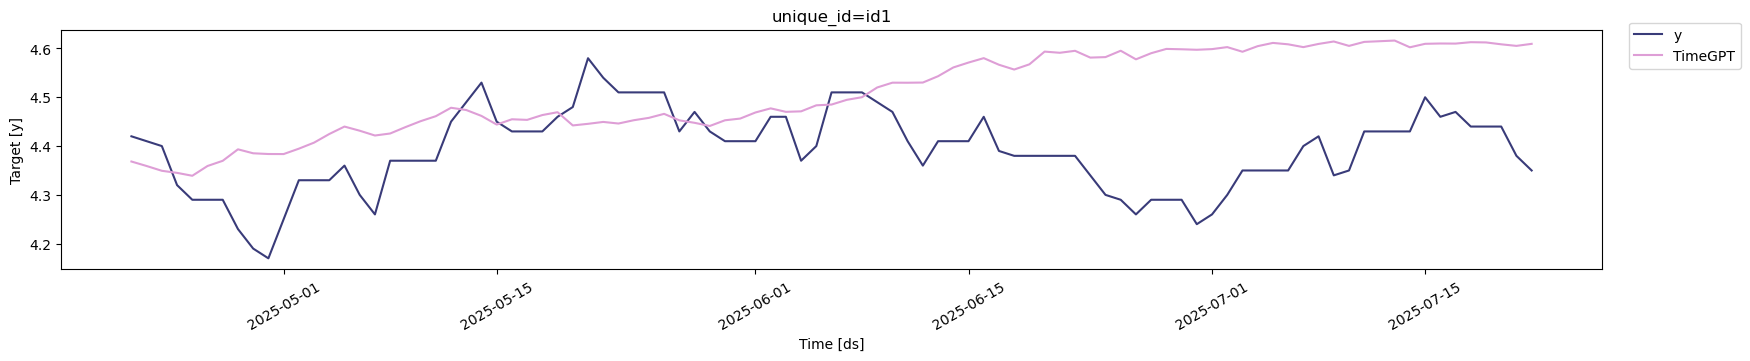

In [57]:
Tneyr_data = treasury_data[['unique_id', 'ds', '10Y_Treasury_Yield']]

#rename 10yr_Treasury_Yield to y
Tneyr_data.rename(columns={'10Y_Treasury_Yield': 'y'}, inplace=True)
print(Tneyr_data.isna().sum())

train_df = Tneyr_data[:-93]
test_df = Tneyr_data[-93:]

#generate a short-term forecast for treasury yield, next 3 months data
timegpt_fcst_df = nixtla_client.forecast(
    df=train_df,
    h=len(test_df), 
    model='timegpt-1-long-horizon'
    )
nixtla_client.plot(test_df, timegpt_fcst_df, time_col='ds', target_col='y')

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: D
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


unique_id    0
ds           0
y            0
dtype: int64


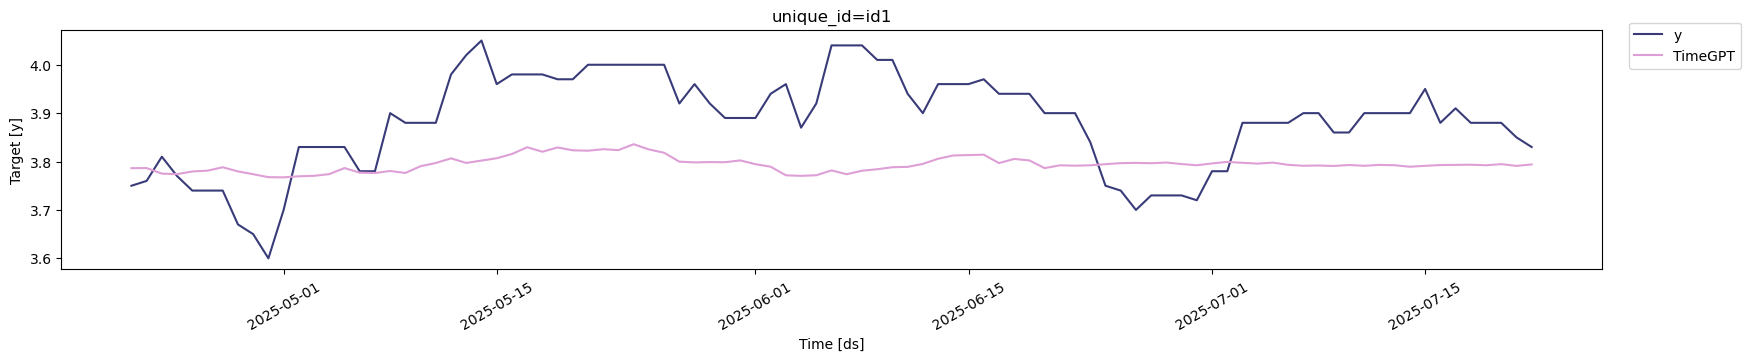

In [58]:
Twoyr_data = treasury_data[['unique_id', 'ds', '2Y_Treasury_Yield']]

#rename 10yr_Treasury_Yield to y
Twoyr_data.rename(columns={'2Y_Treasury_Yield': 'y'}, inplace=True)
print(Twoyr_data.isna().sum())

train_df = Twoyr_data[:-93]
test_df = Twoyr_data[-93:]

#generate a short-term forecast for treasury yield, next 3 months data
timegpt_fcst_df = nixtla_client.forecast(
    df=train_df,
    h=len(test_df), 
    model='timegpt-1-long-horizon'
    )
nixtla_client.plot(test_df, timegpt_fcst_df, time_col='ds', target_col='y')